In [11]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

In [13]:
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 4
BATCH_SIZE = 32
EPOCHS = 2
FINE_TUNE_EPOCHS = 10
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.3

In [14]:
TRAIN_DIR = "D:\\ML\\Plant_disease_2\\New Plant Diseases Dataset(Augmented)\\New Plant Diseases Dataset(Augmented)\\train"
VAL_DIR = "D:\\ML\\Plant_disease_2\\New Plant Diseases Dataset(Augmented)\\New Plant Diseases Dataset(Augmented)\\valid"

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



Found 3060 images belonging to 4 classes.
Found 1758 images belonging to 4 classes.


In [16]:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE,
    pooling='avg'
)

base_model.trainable = False

print(f"Base model loaded: {base_model.name}")
print(f"Base model parameters: {base_model.count_params():,}")

inputs = keras.Input(shape=INPUT_SHAPE)

x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)
x = layers.RandomBrightness(0.1)(x)
x = layers.RandomContrast(0.1)(x)

x = keras.applications.efficientnet.preprocess_input(x)

x = base_model(x, training=False)

x = layers.BatchNormalization()(x)
x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.Dense(512, activation='relu', name='dense_1')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.Dense(256, activation='relu', name='dense_2')(x)
x = layers.Dropout(DROPOUT_RATE/2)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)

model = keras.Model(inputs, outputs)

print(f"Complete model created!")
print(f"Total parameters: {model.count_params():,}")

Base model loaded: efficientnetb0
Base model parameters: 4,049,571
Complete model created!
Total parameters: 4,844,967


In [17]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_1             │ (None, 224, 224, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,844,967 (18.48 MB)

 Trainable params: 791,812 (3.02 MB)

 Non-trainable params: 4,053,155 (15.46 MB)

In [19]:
callbacks = [
    ModelCheckpoint(
        'best_plant_disease_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured:")
for callback in callbacks:
    print(f"- {callback.__class__.__name__}")

Callbacks configured:
- ModelCheckpoint
- EarlyStopping
- ReduceLROnPlateau


In [20]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/2
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4461 - loss: 1.6402
Epoch 1: val_accuracy improved from -inf to 0.24687, saving model to best_plant_disease_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.4462 - loss: 1.6397 - val_accuracy: 0.2469 - val_loss: 1.4209 - learning_rate: 0.0010
Epoch 2/2
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.4674 - loss: 1.5094
Epoch 2: val_accuracy did not improve from 0.24687
96/96 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.4675 - loss: 1.5090 - val_accuracy: 0.2469 - val_loss: 1.5209 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


In [21]:
print("="*50)
print("STAGE 2: Fine-tuning with unfrozen base model")
print("="*50)

# Unfreeze the base model
base_model.trainable = True

# Use a lower learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Base model unfrozen. Trainable parameters: {model.count_params():,}")

# Continue training with fine-tuning
fine_tune_history = model.fit(
    train_generator,
    epochs=EPOCHS + FINE_TUNE_EPOCHS,
    initial_epoch=len(history.history['loss']),
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)


STAGE 2: Fine-tuning with unfrozen base model
Base model unfrozen. Trainable parameters: 4,844,967
Epoch 3/12
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5819 - loss: 1.1414
Epoch 3: val_accuracy did not improve from 0.24687
96/96 ━━━━━━━━━━━━━━━━━━━━ 486s 5s/step - accuracy: 0.5825 - loss: 1.1397 - val_accuracy: 0.2469 - val_loss: 1.7315 - learning_rate: 1.0000e-04
Epoch 4/12
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7350 - loss: 0.7420
Epoch 4: val_accuracy improved from 0.24687 to 0.25085, saving model to best_plant_disease_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 429s 4s/step - accuracy: 0.7350 - loss: 0.7418 - val_accuracy: 0.2509 - val_loss: 1.6023 - learning_rate: 1.0000e-04
Epoch 5/12
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7459 - loss: 0.6709
Epoch 5: val_accuracy improved from 0.25085 to 0.46985, saving model to best_plant_disease_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 433s 4s/step - accuracy: 0.7460 - loss: 0.6708 - val_accuracy: 0.4699 - val_loss

In [22]:
for key in history.history.keys():
    history.history[key].extend(fine_tune_history.history[key])

print("Fine-tuning completed!")

Fine-tuning completed!


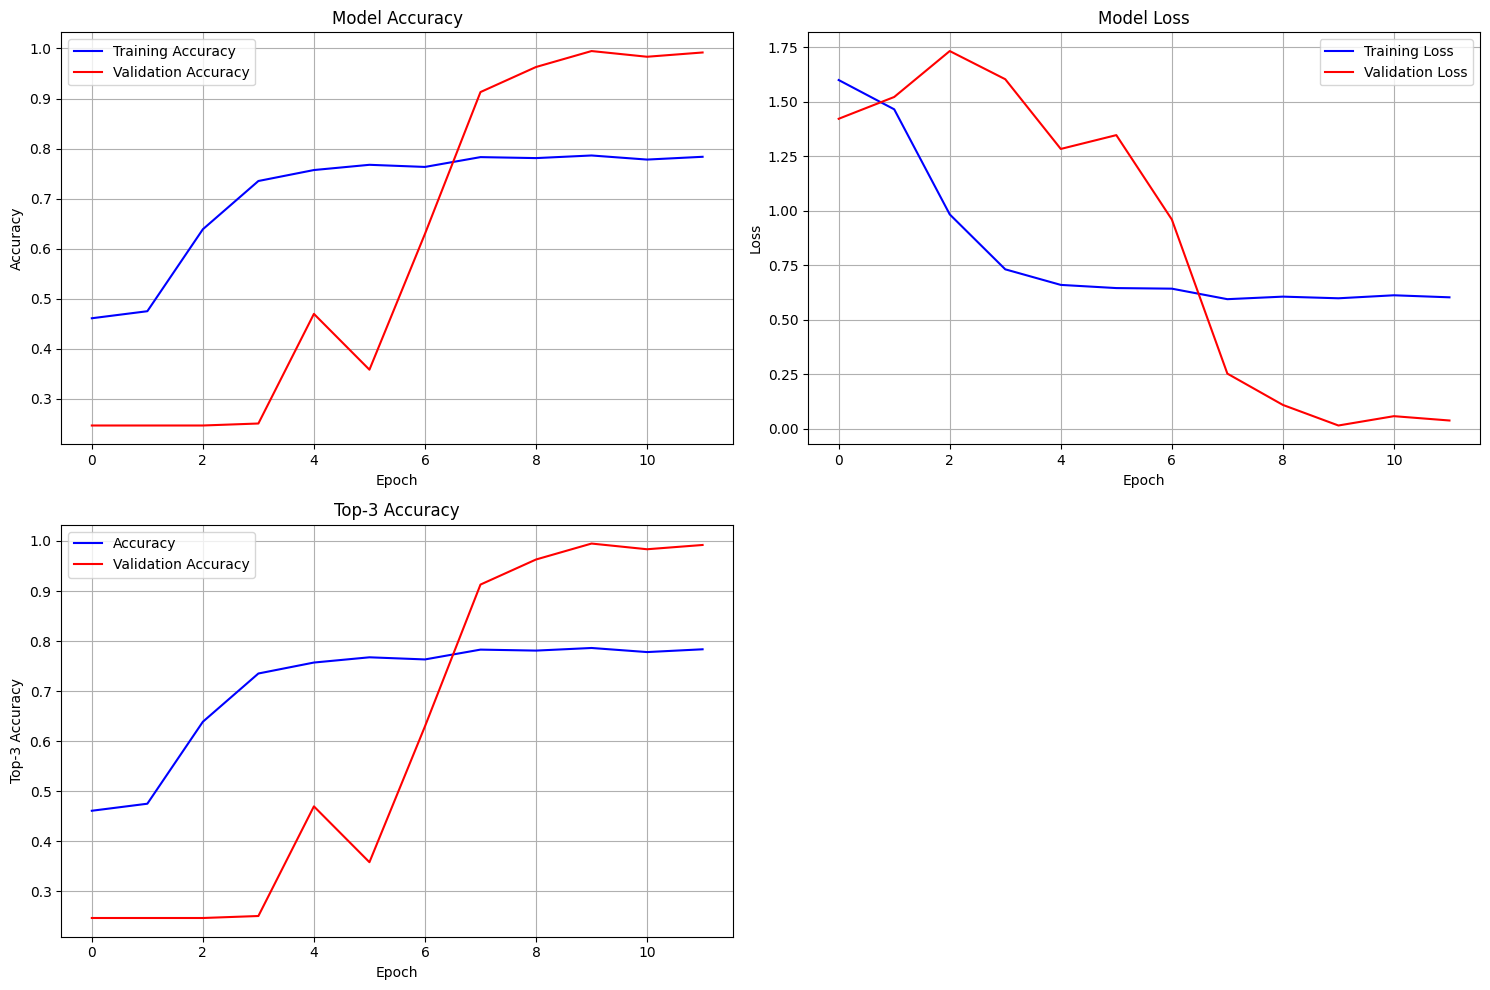

Final Training Accuracy: 0.7837
Final Validation Accuracy: 0.9920
Best Validation Accuracy: 0.9949


In [23]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot training & validation accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot training & validation loss
axes[0, 1].plot(history.history['loss'], label='Training Loss', color='blue')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot top-3 accuracy
axes[1, 0].plot(history.history['accuracy'], label='Accuracy', color='blue')
axes[1, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axes[1, 0].set_title('Top-3 Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Top-3 Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot learning rate if available
if 'lr' in history.history:
    axes[1, 1].plot(history.history['lr'], label='Learning Rate', color='green')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
else:
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Print final training results
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
